<a href="https://colab.research.google.com/github/MichalPietruszevski/NeuralNetworks/blob/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>BANK CUSTOMER CHURN MODELLING</h1></center>

![alt text](https://www.agilitypr.com/wp-content/uploads/2017/10/bank-1.jpg)

## Import necessary packages

In [0]:
import numpy as np
import pandas as pd
import sklearn
import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import  StandardScaler

Using TensorFlow backend.


<center><h3>WCZYTUJEMY DANE Z REPOZYTORIUM</h3>
i zapisujemy je w formie ramki danych.</center>

In [0]:
url = 'https://raw.githubusercontent.com/Dalthirr/NeuralNetworks/master/Churn_Modelling.csv'
df=pd.read_csv(url) #Pobieranie danych

Wywołam komendy <b>head() info() </b>i <b>describe()</b> by zobaczyć dane, z którymi będę pracować.<br> Będę to powtarzać po każdej zmiannie na dataframe.

*   List item
*   List item




In [0]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Sprawdzamy typ zmiennych i czy nie mamy braków.<br/>
  Jak widać, nie ma żadnych braków. Wszytskie zmienne mają równą liczność rekordów wynoszącą <b> 1000 <b/>.



In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [0]:
df.count()

RowNumber          10000
CustomerId         10000
Surname            10000
CreditScore        10000
Geography          10000
Gender             10000
Age                10000
Tenure             10000
Balance            10000
NumOfProducts      10000
HasCrCard          10000
IsActiveMember     10000
EstimatedSalary    10000
Exited             10000
dtype: int64

**Dane** wyglądają na kompletne, w każdej kolumnie znajduje się tyle samo niepustych wierszy.<br> Typy danych w kolumnach również się zgadzają, tzn. mamy <strong>int/float</strong> tam gdzie spodziewamy się liczb i object w miejscu stringów.<br> Niektóre kolumny możnaby przeformatować z <strong>int64</strong>na <strong>int16/bool </strong> w celu zwiększenia prędkości przetwarzania,<br> ale nie jestem pewien czy dla 10000 rekordów różnica będzie zauważalna.

#### Opis zmiennych:
* **RowNumber** - numer wiersza, primary key data frame'a.
* **CustomerId** - numer id klienta.
* **Surname** - nazwisko klienta.
* **CreditScore** - scoring kredytowy, liczba określająca wiarygodność kredytową klienta, im większy tym bardziej wiarygodny klient.
* **Geography** - kraj pochodzenia klienta.
* **Gender** - płeć.
* **Age** - wiek.
* **Tenure** - jak długo klient jest związany z bankiem(<b>w latach</b>).
* **Balance** - saldo bankowe klienta (<b>w dolarach</b>).
* **NumOfProducts** - liczba usług bankowych z których korzysta klient.
* **HasCrCard** - zmienna określająca czy klient posiada w banku kartę kredytową, <b>1 = tak, 0 = nie</b>
* **IsActiveMember** - czy klient jest aktywnym członkiem banku, <b>1 = tak, 0 = nie</b>
* **EstimatedSalary** - szacowane roczne zarobki klienta (<b>w dolarach</b>)
* **Exited** - czy klient zrezygnował z usług banku. <b> 1 = tak, 0 = nie </b>

In [0]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<br>
<center> Wyrzucamy dane, które są zbedne takie jak <b>numer identyfikacyjnym, nazwisko czy numer wiersza.</b></center>
<br>

In [0]:
df = df.drop(["CustomerId", "Surname", "RowNumber"],
        axis=1).sort_values(by="EstimatedSalary")
df.head(5)

KeyError: ignored

W danych nie ma żadnych braków i patrząc na statystyki opisowe dane liczbowe wyglądają sensownie, <br>poza szacowanymi zarobkami, które mają sporo podejrzanie niskich wartości jak na zarobki roczne.<br> 

<hr>
<br>
<center>Pozostaje zakodować dane kategoryczne dotyczące płci i kraju pochodzenia. <br>Użyję do tego dummy encodingu <br>
  (<b> ONE HOT ENCODING</b> z usunięciem pierwszej kolumny )</center>
<br>
<i>pandas.DataFrame.concat()</i> - łączy kolumny wzledem pewnej logiki.<br>
<i>pandas.DataFrame.get_dummies()</i> - ze zmiennej kategorialnej tworzy kilka zmiennych instrumentalnych (licz. nowych zmiennych = licz. kategorii - 1).

In [0]:
df = pd.concat([df, pd.get_dummies(df[["Gender", "Geography"]], drop_first=True)],
               sort=False, axis=1).drop(df[["Gender", "Geography"]], axis=1)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2362 to 6646
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Gender_Male          10000 non-null uint8
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 810.5 KB


In [0]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
2362,709,45,4,122917.71,1,1,1,11.58,1,1,1,0
9647,625,31,5,0.00,2,0,1,90.07,0,1,0,0
9010,645,59,8,121669.93,2,0,0,91.75,1,0,1,0
5548,710,38,2,0.00,2,1,0,96.27,0,1,0,0
4989,629,40,9,0.00,1,1,0,106.67,0,1,0,0


<br>
<center> Sprawdzenie wartości unikalnych dla każdej zmiennej w celu znalezienia potencjanych braków danych.</center>
<br>
<i>pandas.DataFrame.unique() </i> - wyrzuca wartości unikalne dla danego zbioru.

In [0]:
#Wypiszę wartości unikalne dla każdej zmiennej. Chcę dzięki temu wychwycić możliwe missing values
for i in range(len(df.columns)):
        print(df.columns[i])
        print(pd.unique(df.iloc[0:,i]))

CreditScore
[709 625 645 710 629 708 718 621 811 551 616 649 530 715 520 557 556 766
 663 714 542 751 777 736 571 731 572 642 624 614 807 623 521 648 667 605
 850 682 697 678 727 668 570 651 753 416 763 652 528 640 435 650 559 698
 665 829 773 596 679 721 611 695 733 656 672 700 552 562 737 538 711 730
 646 659 686 587 511 590 712 833 687 655 772 526 472 632 740 792 493 606
 463 591 729 536 748 674 483 615 783 703 681 619 539 735 798 643 636 815
 585 662 705 671 622 782 549 726 691 524 434 824 658 696 466 518 496 741
 430 647 677 415 680 690 670 676 592 673 732 654 516 819 749 567 831 846
 722 458 693 757 754 589 540 566 560 464 644 600 514 609 522 490 641 638
 684 599 506 666 742 502 452 602 633 789 565 579 584 728 531 576 597 595
 755 805 756 574 459 588 653 569 657 593 534 613 594 547 480 581 583 626
 563 479 470 707 586 508 745 554 489 689 509 494 620 639 634 784 704 413
 779 630 706 523 532 688 803 558 578 781 785 491 608 769 422 604 467 580
 617 607 553 752 561 564 692 818 776 53

<h4>Macierz korelacji w formie <b> heatmap'y.</b></h4>
<i>seaborn.heatmap()</i> - przyjmuje wartości korelacji i drukuje je w postaci natężenia barwy. 

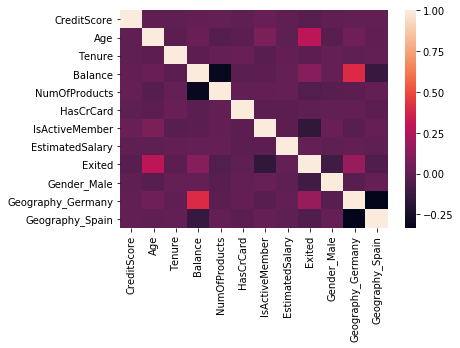

In [0]:
plt.show(sns.heatmap(df.corr(),xticklabels=df.corr().columns,
        yticklabels=df.corr().columns))

Heatmap pokazaję nam, że nie na tyle dużej korelacji pomiędzy dwoma zmiennymi, że możemy sobie pozwolić odrzucenie jednej ze zmiennych.

Korelacja na którą można zwrócić uwagę to korelacja miedzy:
- Stanem konta, a krajem pochodzenie. Osoby z Hiszpani wykazują dodatnią korelację, a Niemcy ujemną.
- Widać też korelacje między wiekiem, a decyzją o pozostaniu klientem banku (nasz target).

<center><h2>Zobaczmy histogramy zmiennch by zobaczyć ich rozkład.</h2></center>

<Figure size 432x288 with 0 Axes>

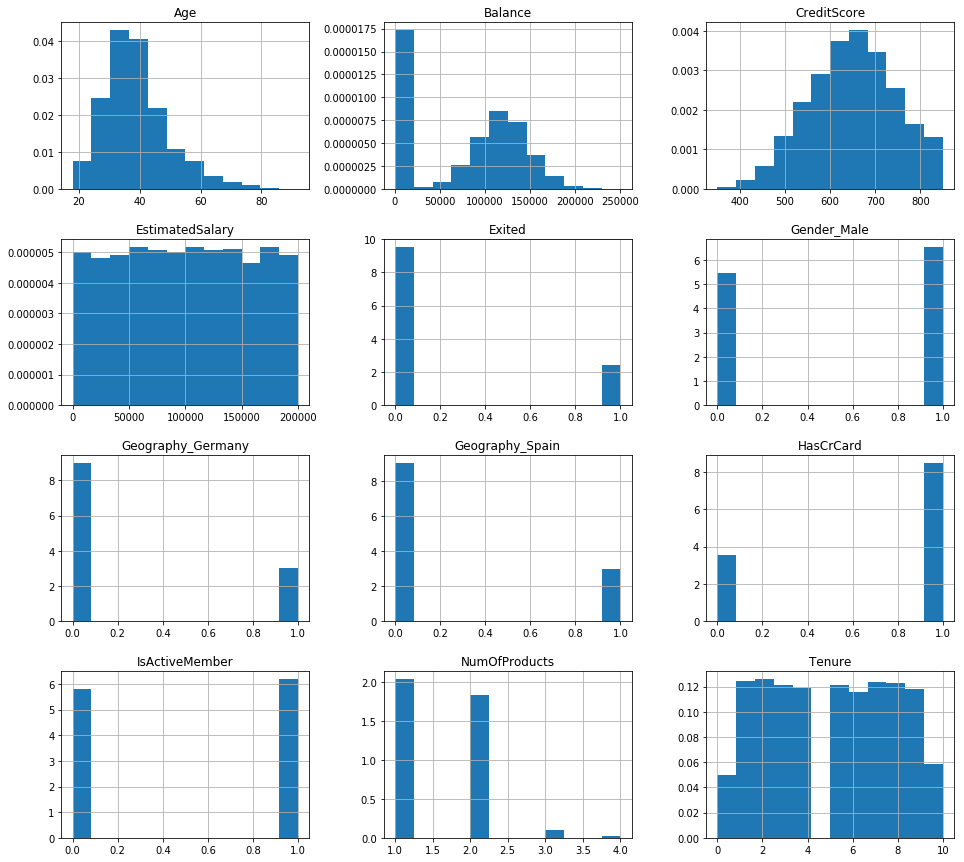

In [0]:
df.hist(figsize=(16,15),bins = 12,density=True);
plt.show();



Na podstawie histogramów, możemy zauważyć, że wiek, stan konta, credit score zdają się być z rozkładu normalnego, a pensja i liczba lat współpracy z klientem rozkład jednostajny.
Pozostałe zmienne są binarne.


Wykonam kilka pairplotow, by zobaczyć, jak różne cechy wpływają na nasz target.

<i>seaborn.countplot()</i> - tworzy wykres słupkowy zmiennej sumując liczność każdej z jej kategorii


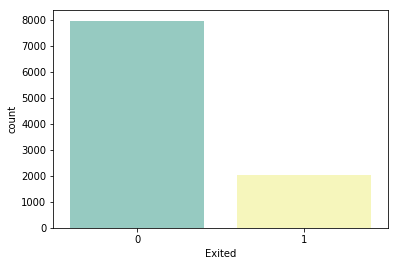

In [0]:
#Liczności zmiennej opisującej wyjście lub pozostanie w banku
ax = sns.countplot(x='Exited', data=df, palette='Set3')
df.loc[:,'Exited'].value_counts()
plt.show()

Jak widać zdecydowana większość badanych klientów nie zrezygnowała z usług banku.


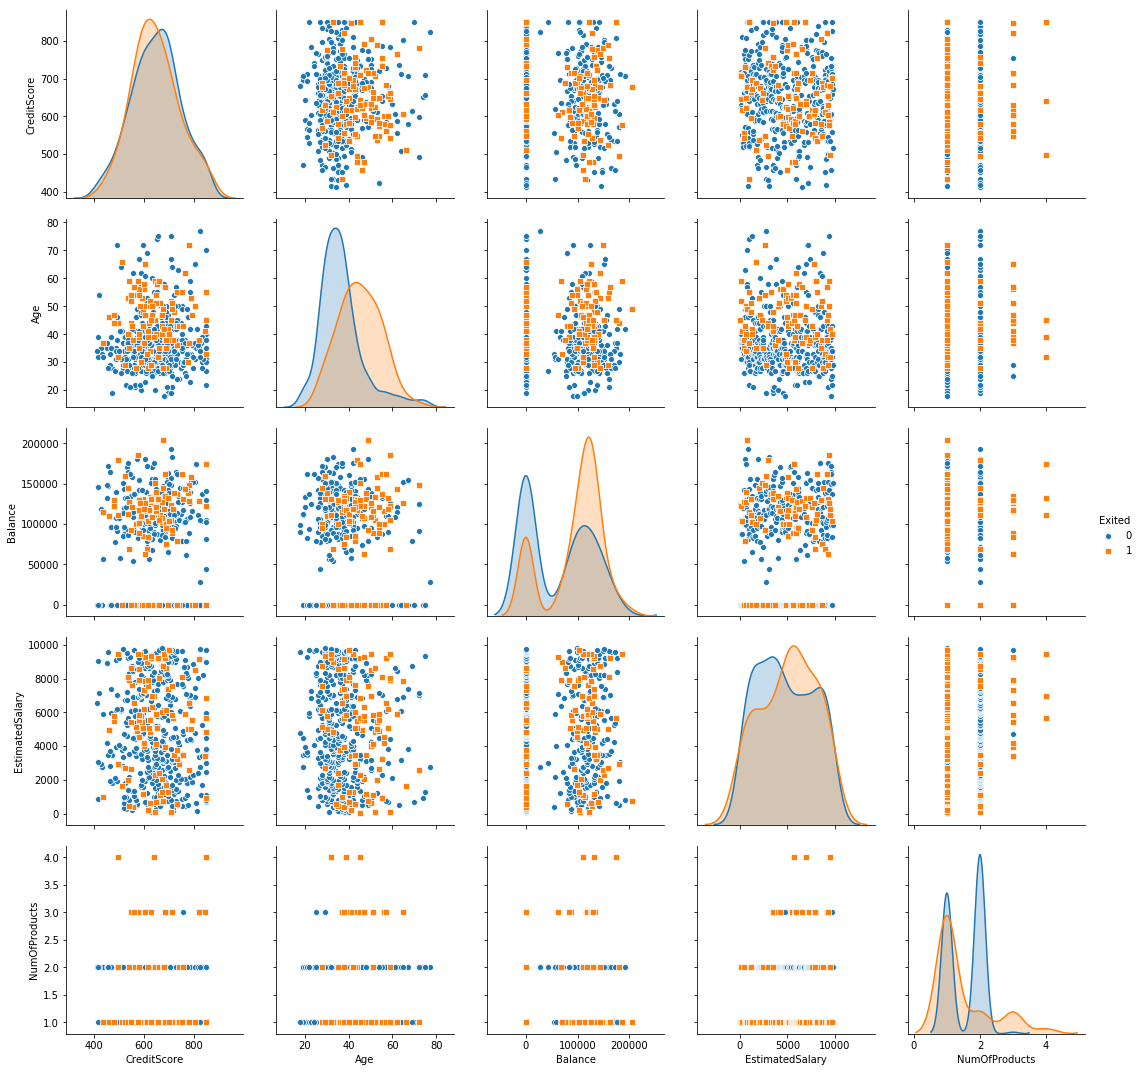

In [0]:
a=['CreditScore','Age','Balance','EstimatedSalary','NumOfProducts']
sns.pairplot(df.iloc[0:500,:],x_vars=a,y_vars=a,hue='Exited',diag_kind='auto',height=3,markers=["o", "s"])

3617


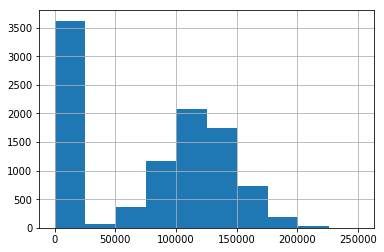

In [0]:
df.Balance.hist()
ast = sorted(df.Balance.values.tolist())
print(ast.count(0))

**Podsumowanie**
 
 1. Osoby młode niezależnie od stanu konta są bardziej skłonne do zmianny konta.
 2. Mamy kilka osób, które mają bardzo niskie roczne przychody. Może to wynikać z różnych czynników. 
 <br> Model można zbudować z nimi i bez nich, jednak przy tak małej liczbie nie powinno mieć to znaczenia. 
 3. Saldo bankowe ma niecodzienny rozkład. Wiele wartości oscyluje koło zera (<b>3617</b>). 
 
